In [1]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
s = 2
r = 0.03
rho = 0.05
z1 = .1
z2 = .2
z = np.array([z1,z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1,la2])
I=500
amin=-0.02
amax=2
a=np.linspace(amin, amax, I)
da=(amax-amin)/(I-1)
aa=np.array([a,a]).T
zz=np.ones((I,1))*z


"""Initial guess"""
v01 = (z[0]+r*a)**(1-s)/(1-s)/rho
v02 = (z[1]+r*a)**(1-s)/(1-s)/rho
v0=np.array([v01,v02]).T
v=copy.deepcopy(v0)

maxit= 100
Delta = 1000
crit = 10**(-6)

dVf = np.zeros((I,2))
dVb = np.zeros((I,2))
c=np.zeros((I,2))

Aswitch1 = scipy.sparse.hstack([-scipy.sparse.eye(I)*la1, scipy.sparse.eye(I)*la1])
Aswitch2 = scipy.sparse.hstack([scipy.sparse.eye(I)*la2, -scipy.sparse.eye(I)*la2])
Aswitch = scipy.sparse.vstack([Aswitch1, Aswitch2])

dist=np.zeros(maxit)

In [2]:
for n in range(maxit):
    V = copy.deepcopy(v)
    ## forward difference method eq.(8)
    dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVf[I-1,:] = 1 ## never be used, but set 1 make sure there is no exception
    ## backward difference method eq.(8)
    dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVb[0,:] = (z+r*amin)**(-s)
    ## consumption and savings with forward difference     u=x^(1-s)/1-s  => (u')^-1: x^(-1/s) 
    cf = dVf**(-1/s)
    sf = zz + r*aa - cf
    ## consumption and savings with backward difference
    cb = dVb**(-1/s)
    sb = zz + r*aa - cb
    ## consumption and derivative of value function at steady state
    c0 = zz + r*aa
    dV0 = c0**(-s)
    ## the indicator of upwind scheme 
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)     ## sijF<0<sijB
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0
    ## compute c and u
    c = dV_Upwind**(-1/s)
    u = c**(1-s)/(1-s)
    ## CONSTRUCT MATRIX
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    A1 = scipy.sparse.spdiags(Y[:,0],0,I,I)+scipy.sparse.spdiags(X[1:,0],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,0]]),1,I,I)
    A2 = scipy.sparse.spdiags(Y[:,1],0,I,I)+scipy.sparse.spdiags(X[1:,1],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,1]]),1,I,I)
    A = scipy.sparse.vstack([scipy.sparse.hstack([A1, scipy.sparse.csc_matrix((I,I))]), scipy.sparse.hstack([scipy.sparse.csc_matrix((I,I)), A2])]) + Aswitch
    B = (rho + 1/Delta)*scipy.sparse.eye(2*I) - A
    u_stacked = np.vstack((u[:,0].reshape((I,1)), u[:,1].reshape((I,1))))
    V_stacked = np.vstack([V[:,0].reshape((I,1)), V[:,1].reshape((I,1))])
    b = u_stacked + V_stacked/Delta
    V_stacked = scipy.sparse.linalg.spsolve(B, b)
    V[:,0] = np.squeeze(V_stacked[0:I])
    V[:,1] = np.squeeze(V_stacked[I:])
    Vchange = V - v
    v=copy.deepcopy(V)
    dist[n] = np.max(np.abs(Vchange))
    if dist[n] < crit:
        print("Value function is converged. Iteration is:", n)
        break

Value function is converged. Iteration is: 10


In [3]:
adot = zz + r*aa - c

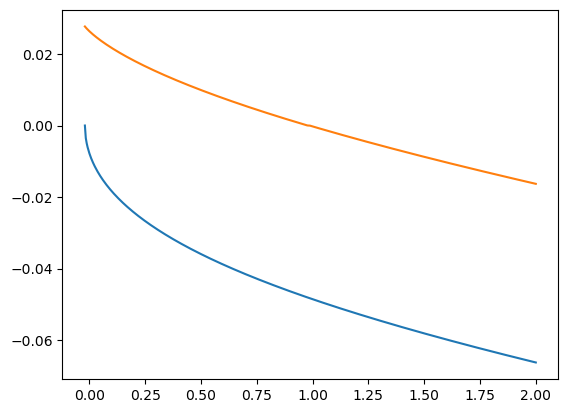

In [4]:
import matplotlib.pyplot as plt
plt.plot(a, adot)

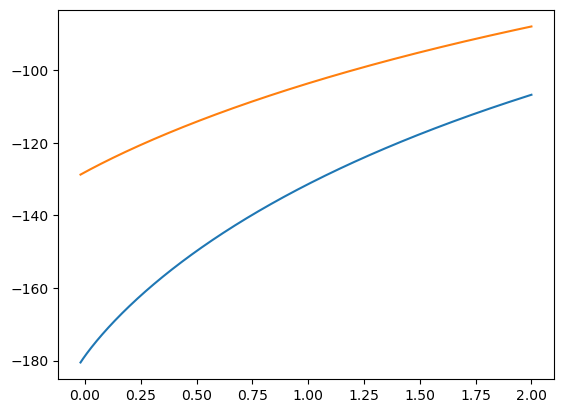

In [5]:
plt.plot(a, v)

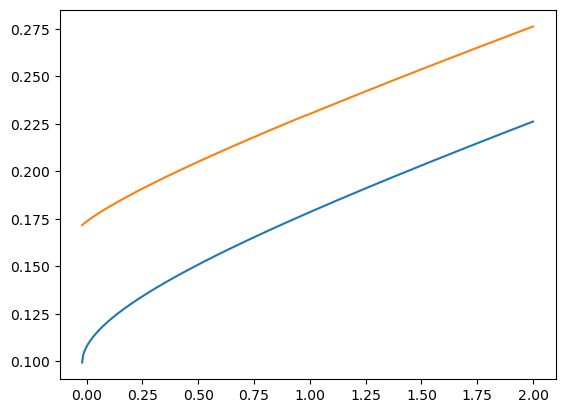

In [6]:
plt.plot(a, c)

In [3]:
c

array([[0.0994    , 0.17170619],
       [0.10303285, 0.1721272 ],
       [0.10460557, 0.1725269 ],
       [0.10583224, 0.172912  ],
       [0.10687909, 0.17328584],
       [0.10781083, 0.17365048],
       [0.10866074, 0.1740073 ],
       [0.10944864, 0.17435732],
       [0.11018743, 0.17470133],
       [0.11088611, 0.17503996],
       [0.11155122, 0.17537371],
       [0.1121877 , 0.175703  ],
       [0.1127994 , 0.17602819],
       [0.11338935, 0.17634958],
       [0.11396005, 0.17666743],
       [0.11451354, 0.17698197],
       [0.11505152, 0.17729342],
       [0.11557543, 0.17760195],
       [0.11608651, 0.17790772],
       [0.11658582, 0.17821088],
       [0.11707429, 0.17851156],
       [0.11755273, 0.17880989],
       [0.11802186, 0.17910596],
       [0.11848231, 0.17939989],
       [0.11893464, 0.17969177],
       [0.11937938, 0.17998167],
       [0.11981696, 0.18026969],
       [0.12024781, 0.18055588],
       [0.12067231, 0.18084034],
       [0.12109079, 0.1811231 ],
       [0.

In [4]:
c0

array([[0.0994    , 0.1994    ],
       [0.09952144, 0.19952144],
       [0.09964289, 0.19964289],
       [0.09976433, 0.19976433],
       [0.09988577, 0.19988577],
       [0.10000721, 0.20000721],
       [0.10012866, 0.20012866],
       [0.1002501 , 0.2002501 ],
       [0.10037154, 0.20037154],
       [0.10049299, 0.20049299],
       [0.10061443, 0.20061443],
       [0.10073587, 0.20073587],
       [0.10085731, 0.20085731],
       [0.10097876, 0.20097876],
       [0.1011002 , 0.2011002 ],
       [0.10122164, 0.20122164],
       [0.10134309, 0.20134309],
       [0.10146453, 0.20146453],
       [0.10158597, 0.20158597],
       [0.10170741, 0.20170741],
       [0.10182886, 0.20182886],
       [0.1019503 , 0.2019503 ],
       [0.10207174, 0.20207174],
       [0.10219319, 0.20219319],
       [0.10231463, 0.20231463],
       [0.10243607, 0.20243607],
       [0.10255752, 0.20255752],
       [0.10267896, 0.20267896],
       [0.1028004 , 0.2028004 ],
       [0.10292184, 0.20292184],
       [0.